### Import Packages

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import time 
import math
from pandas_profiling import ProfileReport
import missingno as msno


### Import Files


In [2]:
train_df_csv= pd.read_csv('train.csv')
test_df_csv= pd.read_csv('test.csv')
test_label= test_df_csv['PassengerId']
# print(test_df_csv)

### Data Observation

In [3]:
report= ProfileReport(train_df_csv)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True  
<c

<AxesSubplot:>

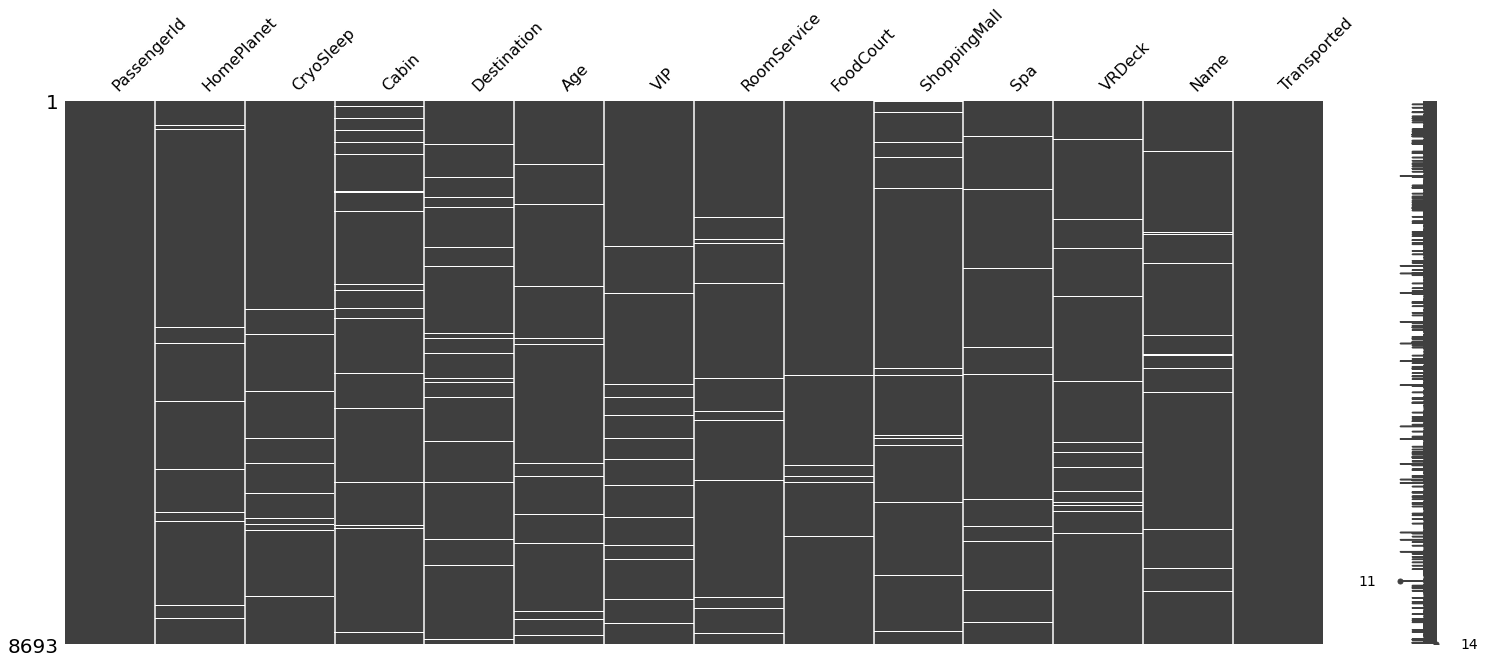

In [4]:
print(train_df_csv.head())
print(train_df_csv.info())
print(train_df_csv.isna().sum())
msno.matrix(train_df_csv)

### Data Preprocessing



In [5]:
#create new col for number of family members, no data has more than 10 family members, so get the last digit will be sufficient
train_df_csv['Fam_num']= train_df_csv['PassengerId'].str.split('_0',expand= True)[1].astype(int)
test_df_csv['Fam_num']= test_df_csv['PassengerId'].str.split('_0',expand= True)[1].astype(int)

#split cabin info
train_df_csv[['Cabin_deck', 'Cabin_num', 'Cabin_side']]= train_df_csv['Cabin'].str.split('/',expand= True)
test_df_csv[['Cabin_deck', 'Cabin_num', 'Cabin_side']]= test_df_csv['Cabin'].str.split('/',expand= True)

train_df_csv['Cabin_num']= train_df_csv['Cabin_num'].astype(float)
test_df_csv['Cabin_num']= train_df_csv['Cabin_num'].astype(float)

train_df_csv= train_df_csv.drop(columns= ['Cabin', 'Name'])
test_df_csv= test_df_csv.drop(columns= ['Cabin', 'Name'])

#Trun T/F to 1/0
train_df_csv['CryoSleep']= train_df_csv['CryoSleep'].astype(float)
train_df_csv['VIP']= train_df_csv['VIP'].astype(float)
train_df_csv['Transported']= train_df_csv['Transported'].astype(float)


test_df_csv['CryoSleep']= test_df_csv['CryoSleep'].astype(float)
test_df_csv['VIP']= test_df_csv['VIP'].astype(float)

print(train_df_csv.info())
# print(test_df_csv)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   float64
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   float64
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Transported   8693 non-null   float64
 12  Fam_num       8693 non-null   int64  
 13  Cabin_deck    8494 non-null   object 
 14  Cabin_num     8494 non-null   float64
 15  Cabin_side    8494 non-null   object 
dtypes: float64(10), int64(1), object(5)
memory usage: 1.1+ MB
None


### Eploratory Data Analysis (EDA)


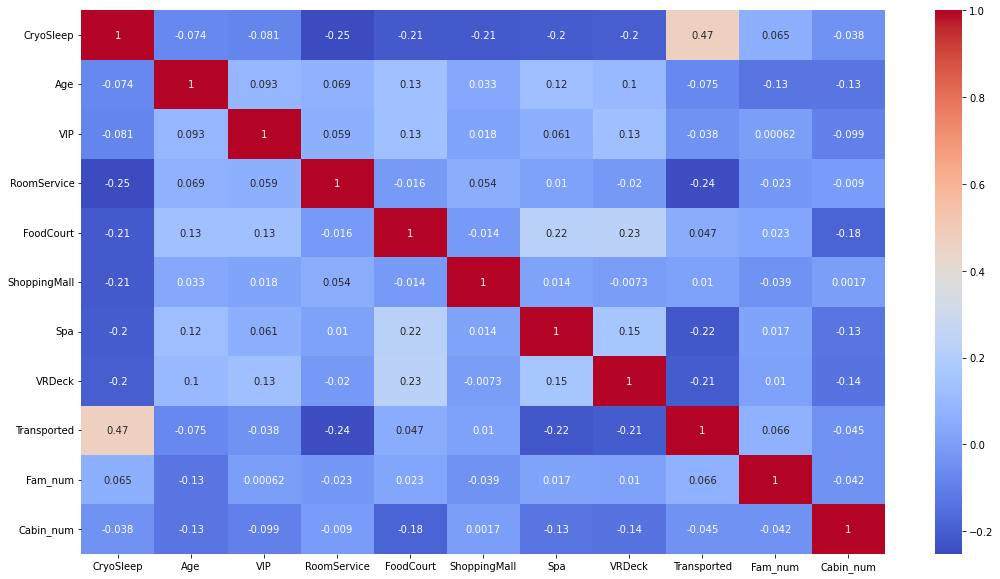

In [6]:
#heatmap correlation
plt.figure(figsize = [18,10])
sns.heatmap(train_df_csv.corr(), annot=True, cmap= 'coolwarm')
plt.show()

In [7]:
print(train_df_csv['HomePlanet'].unique())
print(train_df_csv['CryoSleep'].unique())
print(train_df_csv['Destination'].unique())
print(train_df_csv['Cabin_deck'].unique())
print(train_df_csv['Cabin_num'].unique())
print(train_df_csv['Cabin_side'].unique())

['Europa' 'Earth' 'Mars' nan]
[ 0.  1. nan]
['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
['B' 'F' 'A' 'G' nan 'E' 'D' 'C' 'T']
[0.000e+00 1.000e+00 2.000e+00 ... 1.892e+03 1.893e+03 1.894e+03]
['P' 'S' nan]


### Relationship Observation

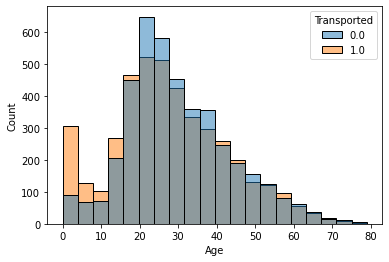

In [8]:
sns.histplot(data= train_df_csv, x='Age', hue= 'Transported',bins=20) 
plt.show()

In [9]:
# According to the graph above, younger passengers seem like having higher chances to be transported 
age_range= [0, 5, 12, 20, 40, 65, np.inf]#split the data to different age bins
group_names= ['baby', 'kid', 'teen', 'young_adult', 'adult', 'old' ] #rename the bins
# Add Age Group Feature to the dataset
train_df_csv['Age_group']= pd.cut(train_df_csv['Age'], bins= age_range, labels= group_names).astype(object)
test_df_csv['Age_group']= pd.cut(test_df_csv['Age'], bins= age_range, labels= group_names).astype(object)

# Removing the un-needed feature
train_df_csv= train_df_csv.drop(columns='Age')
test_df_csv= test_df_csv.drop(columns='Age')
print(train_df_csv.isna().sum())

PassengerId       0
HomePlanet      201
CryoSleep       217
Destination     182
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
Fam_num           0
Cabin_deck      199
Cabin_num       199
Cabin_side      199
Age_group       357
dtype: int64


In [10]:
print(test_df_csv['Age_group'].unique())
# print(test_df_csv)

['young_adult' 'teen' 'adult' 'old' 'kid' nan 'baby']


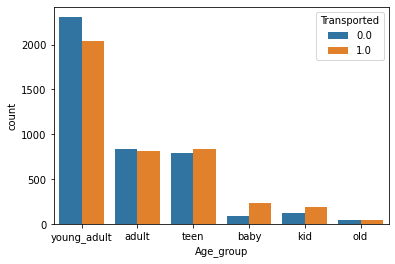

Result: baby and kid are more likely to be transported


In [11]:
# Observe the relationship between Age_group & Transported (Target Variable)
sns.countplot(data= train_df_csv, x='Age_group', hue= 'Transported') 
plt.show()
print('Result: baby and kid are more likely to be transported')

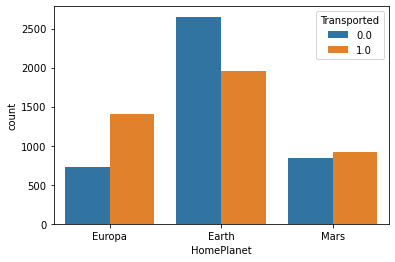

Result: Europa is more likely to be Transported and Earth is less likely


In [12]:
# Observe the relationship between HomePlanet & Transported (Target Variable)
sns.countplot(data= train_df_csv, x='HomePlanet', hue= 'Transported') 
plt.show()

print('Result: Europa is more likely to be Transported and Earth is less likely')

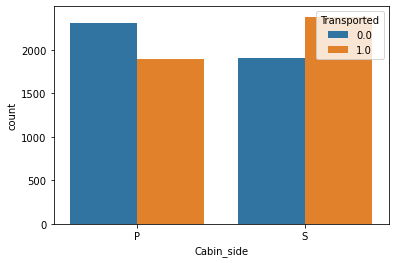

Result: Cabin S is more likely to be Transported but Cabin P is less likely


In [13]:
# Observe the relationship between Cabin_side & Transported (Target Variable)
sns.countplot(data= train_df_csv, x='Cabin_side', hue= 'Transported') 
plt.show()

print('Result: Cabin S is more likely to be Transported but Cabin P is less likely')

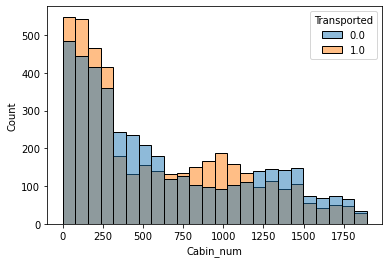

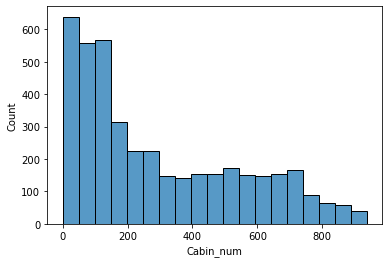

937.0
Result: Cabin_num shoold be splited into 4 groups


In [14]:
# Observe the relationship between Cabin_num & Transported (Target Variable)
sns.histplot(data= train_df_csv, x='Cabin_num', hue= 'Transported') 
plt.show()

sns.histplot(data= test_df_csv, x='Cabin_num') 
plt.show()
print(test_df_csv.Cabin_num.max())
print('Result: Cabin_num shoold be splited into 4 groups')

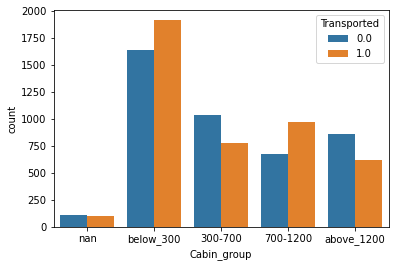

Result: Cabin_group becomes a good feature


In [15]:
cab_num_range= [0, 300, 700, 1200, np.inf]# split the data into groups according to their relationship toward target variable
cabin_group_type= ['below_300', '300-700', '700-1200', 'above_1200' ] #group names
train_df_csv['Cabin_group']= pd.cut(train_df_csv['Cabin_num'], bins= cab_num_range, labels= cabin_group_type).astype(str)
test_df_csv['Cabin_group']= pd.cut(test_df_csv['Cabin_num'],  bins= cab_num_range, labels= cabin_group_type).astype(str)

sns.countplot(data= train_df_csv, x='Cabin_group', hue= 'Transported') 
plt.show()
print('Result: Cabin_group becomes a good feature')


In [16]:
print(train_df_csv['Cabin_group'].unique())

['nan' 'below_300' '300-700' '700-1200' 'above_1200']


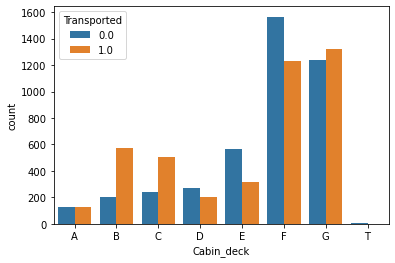

Result: 
More likely to be Transported: B, C, G 
Less likely to be Transported: D, E, F, T 
Consider to drop: A


In [17]:
# Observe the relationship between Cabin_deck & Transported (Target Variable)
order= ['A', 'B', 'C','D', 'E', 'F', 'G', 'T']
sns.countplot(data= train_df_csv, x='Cabin_deck', hue= 'Transported', order= order) 
plt.show()
print('Result: \nMore likely to be Transported: B, C, G \nLess likely to be Transported: D, E, F, T \nConsider to drop: A' )

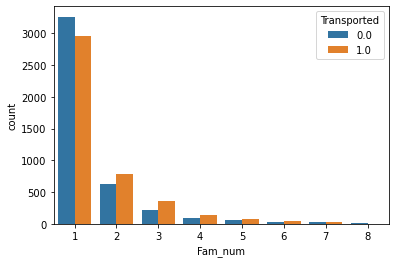

Result: More Family members are more likely to be transported


In [18]:
# Observe the relationship between Fam_num & Transported (Target Variable)
sns.countplot(data= train_df_csv, x='Fam_num', hue= 'Transported') 
plt.show()
print('Result: More Family members are more likely to be transported')

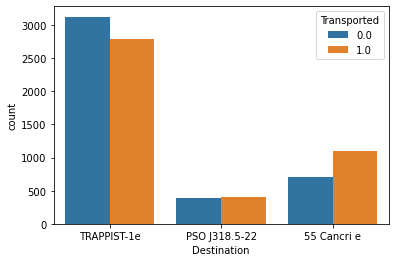

Result: 55 Cancri e is more likely to be Transported but TRAPPIST-1e is less likely


In [19]:
# Observe the relationship between Destination & Transported (Target Variable)
sns.countplot(data= train_df_csv, x='Destination', hue= 'Transported') 
plt.show()
print('Result: 55 Cancri e is more likely to be Transported but TRAPPIST-1e is less likely')


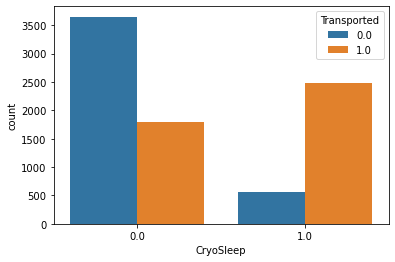

Result: CryoSleep plays an important role in prediting target variable, thus we should drop the missing value instead of replacing with any value
before: 217
before: 93


In [20]:
# Observe the relationship between CryoSleep & Transported (Target Variable)
sns.countplot(data= train_df_csv, x='CryoSleep', hue= 'Transported') 
plt.show()

print('Result: CryoSleep plays an important role in prediting target variable, thus we should drop the missing value instead of replacing with any value')
print('before:',train_df_csv['CryoSleep'].isna().sum())
print('before:',test_df_csv['CryoSleep'].isna().sum())
# print(test_df_csv)
# print('after:',train_df_csv['CryoSleep'].isna().sum())
# print('after:',test_df_csv['CryoSleep'].isna().sum())

# Fill missing values


In [21]:
print('before drop:\n', train_df_csv.isna().sum())

train_df= train_df_csv.fillna({
    'HomePlanet': 'HP_unknown',
    'Destination':train_df_csv['Destination'].mode()[0],
    'VIP':train_df_csv['VIP'].mode()[0],
    'Age_group': 'Age_unknown',
    'RoomService':train_df_csv['RoomService'].median(),
    'FoodCourt':train_df_csv['FoodCourt'].median(),
    'ShoppingMall':train_df_csv['ShoppingMall'].median(),
    'Spa':train_df_csv['Spa'].median(),
    'VRDeck':train_df_csv['VRDeck'].median(),
    'Cabin_deck': train_df_csv['Cabin_deck'].mode()[0],
    'Cabin_num': train_df_csv['Cabin_num'].median(),
    'Cabin_side': train_df_csv['Cabin_side'].mode()[0]
})

test_df=test_df_csv.fillna({
    'HomePlanet': 'HP_unknown',
    'Destination':test_df_csv['Destination'].mode()[0],
    'VIP':test_df_csv['VIP'].mode()[0],
    'Age_group': 'Age_unknown',
    'RoomService':test_df_csv['RoomService'].median(),
    'FoodCourt':test_df_csv['FoodCourt'].median(),
    'ShoppingMall':test_df_csv['ShoppingMall'].median(),
    'Spa':test_df_csv['Spa'].median(),
    'VRDeck':test_df_csv['VRDeck'].median(),
    'Cabin_deck': test_df_csv['Cabin_deck'].mode()[0],
    'Cabin_num': test_df_csv['Cabin_num'].median(),
    'Cabin_side': test_df_csv['Cabin_side'].mode()[0]
})


# train_df= train_df_csv.dropna(subset=['CryoSleep'])
# test_df= test_df_csv.dropna(subset=['CryoSleep'])

print('after drop:\n',train_df.isna().sum())
print('after drop:\n',test_df.isna().sum())

before drop:
 PassengerId       0
HomePlanet      201
CryoSleep       217
Destination     182
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
Fam_num           0
Cabin_deck      199
Cabin_num       199
Cabin_side      199
Age_group       357
Cabin_group       0
dtype: int64
after drop:
 PassengerId       0
HomePlanet        0
CryoSleep       217
Destination       0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
Fam_num           0
Cabin_deck        0
Cabin_num         0
Cabin_side        0
Age_group         0
Cabin_group       0
dtype: int64
after drop:
 PassengerId      0
HomePlanet       0
CryoSleep       93
Destination      0
VIP              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
Fam_num          0
Cabin_deck       0
Cabin_num        0
Cabin_s

### Feature Engineering(Processing CryoSleep Col)

In [22]:
#since the CryoSleep is a very important feature toward predicting Transported, we should use the stongest correlation features to determine 'CryoSleep'

# define new col as lux_exp to sum up the uneccessary spending
train_df['Lux_exp']= train_df['RoomService']+train_df['Spa']+train_df['VRDeck']
test_df['Lux_exp']= test_df['RoomService']+test_df['Spa']+test_df['VRDeck']

# define new col as Total_exp to sum up the total spending

train_df['Total_exp']= train_df['RoomService']+train_df['Spa']+train_df['VRDeck']+train_df['FoodCourt']+train_df['ShoppingMall']
test_df['Total_exp']= test_df['RoomService']+test_df['Spa']+test_df['VRDeck']+test_df['FoodCourt']+test_df['ShoppingMall']

#split Total_exp to 2 categories in new col called: 'costly' 
train_df['costly']=pd.qcut(train_df['Total_exp'], q=2, labels= ['costly_False', 'costly_True']).astype(object)
test_df['costly']=pd.qcut(test_df['Total_exp'], q=2, labels= ['costly_False', 'costly_True']).astype(object)

#using the 'costly' to fill nan in CryoSleep col
train_df['CryoSleep'] = train_df.CryoSleep.fillna(train_df.apply(lambda x : 0 if x.costly == 'costly_False' else (1 if pd.isna(x.CryoSleep) else x.CryoSleep), axis =1))
test_df['CryoSleep'] = test_df.CryoSleep.fillna(test_df.apply(lambda x : 0 if x.costly == 'costly_False' else (1 if pd.isna(x.CryoSleep) else x.CryoSleep), axis =1))

print(train_df.isna().sum())
print(test_df.isna().sum())

PassengerId     0
HomePlanet      0
CryoSleep       0
Destination     0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
Fam_num         0
Cabin_deck      0
Cabin_num       0
Cabin_side      0
Age_group       0
Cabin_group     0
Lux_exp         0
Total_exp       0
costly          0
dtype: int64
PassengerId     0
HomePlanet      0
CryoSleep       0
Destination     0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Fam_num         0
Cabin_deck      0
Cabin_num       0
Cabin_side      0
Age_group       0
Cabin_group     0
Lux_exp         0
Total_exp       0
costly          0
dtype: int64


### Get Dummies

In [23]:
#get dummies
train_df=pd.get_dummies(train_df, columns=['HomePlanet','Destination','Cabin_deck', 'Cabin_side', 'Age_group', 'Cabin_group' ])
# Destination_dm_train=pd.get_dummies(train_df['Destination'])
# Cabin_deck_dm_train=pd.get_dummies(train_df['Cabin_deck'])
# Cabin_side_dm_train=pd.get_dummies(train_df['Cabin_side'])
# Age_group_dm_train=pd.get_dummies(train_df['Age_group'])
# Cabin_group_dm_train= pd.get_dummies(train_df['Cabin_group'])
# costly_dm_train= pd.get_dummies(train_df['costly'])
# train_df= pd.concat([train_df, HomePlanet_dm_train, Destination_dm_train, Cabin_deck_dm_train, Cabin_side_dm_train, Age_group_dm_train, Cabin_group_dm_train,costly_dm_train], axis= 1)
train_label= train_df['Transported']

test_df=pd.get_dummies(test_df, columns=['HomePlanet','Destination','Cabin_deck', 'Cabin_side', 'Age_group', 'Cabin_group' ])
# Destination_dm_test=pd.get_dummies(test_df['Destination'])
# Cabin_deck_dm_test=pd.get_dummies(test_df['Cabin_deck'])
# Cabin_side_dm_test=pd.get_dummies(test_df['Cabin_side'])
# Age_group_dm_test=pd.get_dummies(test_df['Age_group'])
# Cabin_group_dm_test= pd.get_dummies(test_df['Cabin_group'])
# costly_dm_test= pd.get_dummies(test_df['costly'])
# test_df= pd.concat([test_df, HomePlanet_dm_test, Destination_dm_test, Cabin_deck_dm_test, Cabin_side_dm_test,Age_group_dm_test,Cabin_group_dm_test, costly_dm_test], axis= 1)

# Cabin_group in the test set does not have cabin_num above 1200 which will cause feature number mismatch. Thus, we manually fill the number with 0
test_df['above_1200']= 0


### Check feature correlation 

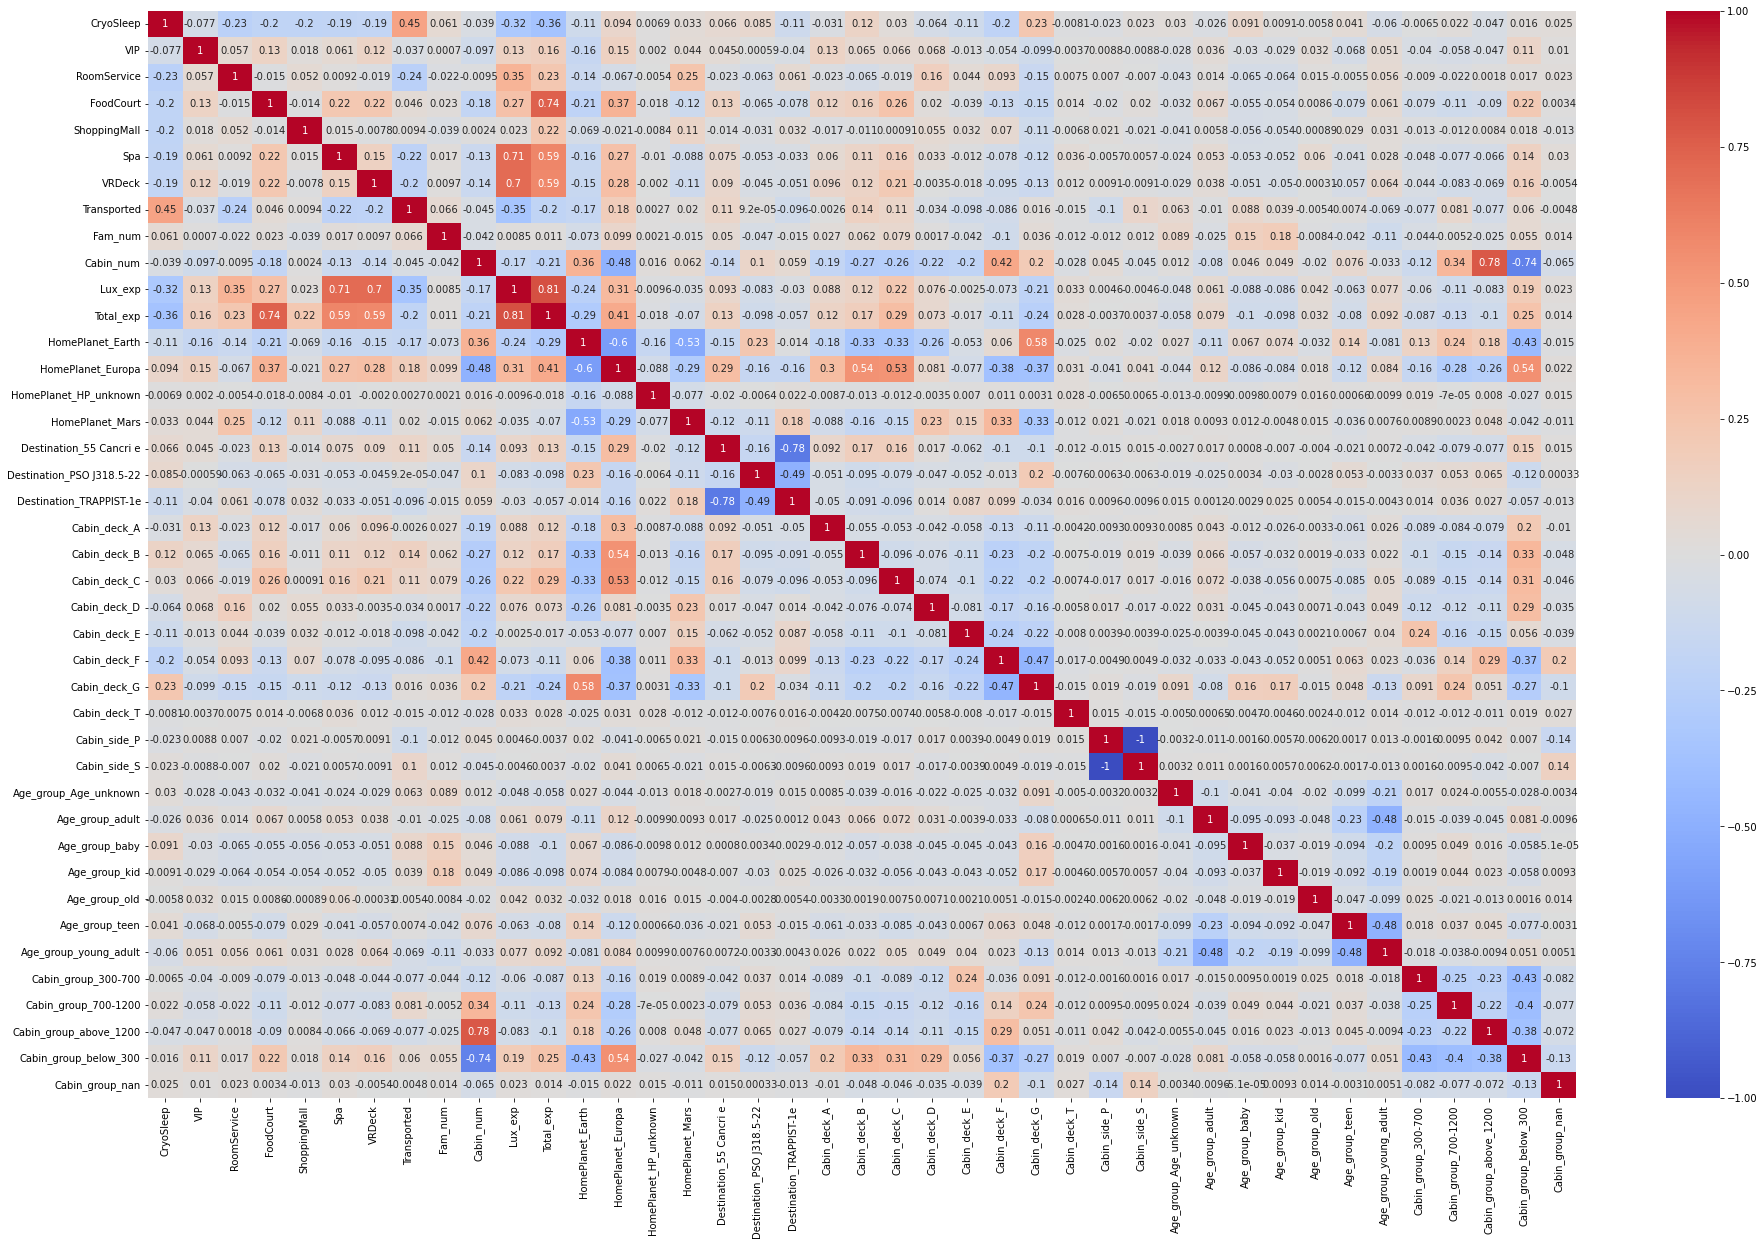

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PassengerId                8693 non-null   object 
 1   CryoSleep                  8693 non-null   float64
 2   VIP                        8693 non-null   float64
 3   RoomService                8693 non-null   float64
 4   FoodCourt                  8693 non-null   float64
 5   ShoppingMall               8693 non-null   float64
 6   Spa                        8693 non-null   float64
 7   VRDeck                     8693 non-null   float64
 8   Transported                8693 non-null   float64
 9   Fam_num                    8693 non-null   int64  
 10  Cabin_num                  8693 non-null   float64
 11  Lux_exp                    8693 non-null   float64
 12  Total_exp                  8693 non-null   float64
 13  costly                     8693 non-null   objec

In [24]:
plt.figure(figsize = [32,20])
sns.heatmap(train_df.corr(), annot=True, cmap= 'coolwarm')
plt.show()
print(train_df.info()) 

### Drop Weak Features 

In [25]:
train_df= train_df.drop(columns=['PassengerId','CryoSleep', 'ShoppingMall','HomePlanet_HP_unknown','Destination_PSO J318.5-22','Cabin_deck_A', 'Age_group_old','Age_group_teen', 'Cabin_group_nan','costly'], axis=1)
test_df= test_df.drop(columns=['PassengerId','CryoSleep', 'ShoppingMall','HomePlanet_HP_unknown','Destination_PSO J318.5-22','Cabin_deck_A', 'Age_group_old','Age_group_teen', 'Cabin_group_nan','costly'], axis=1)



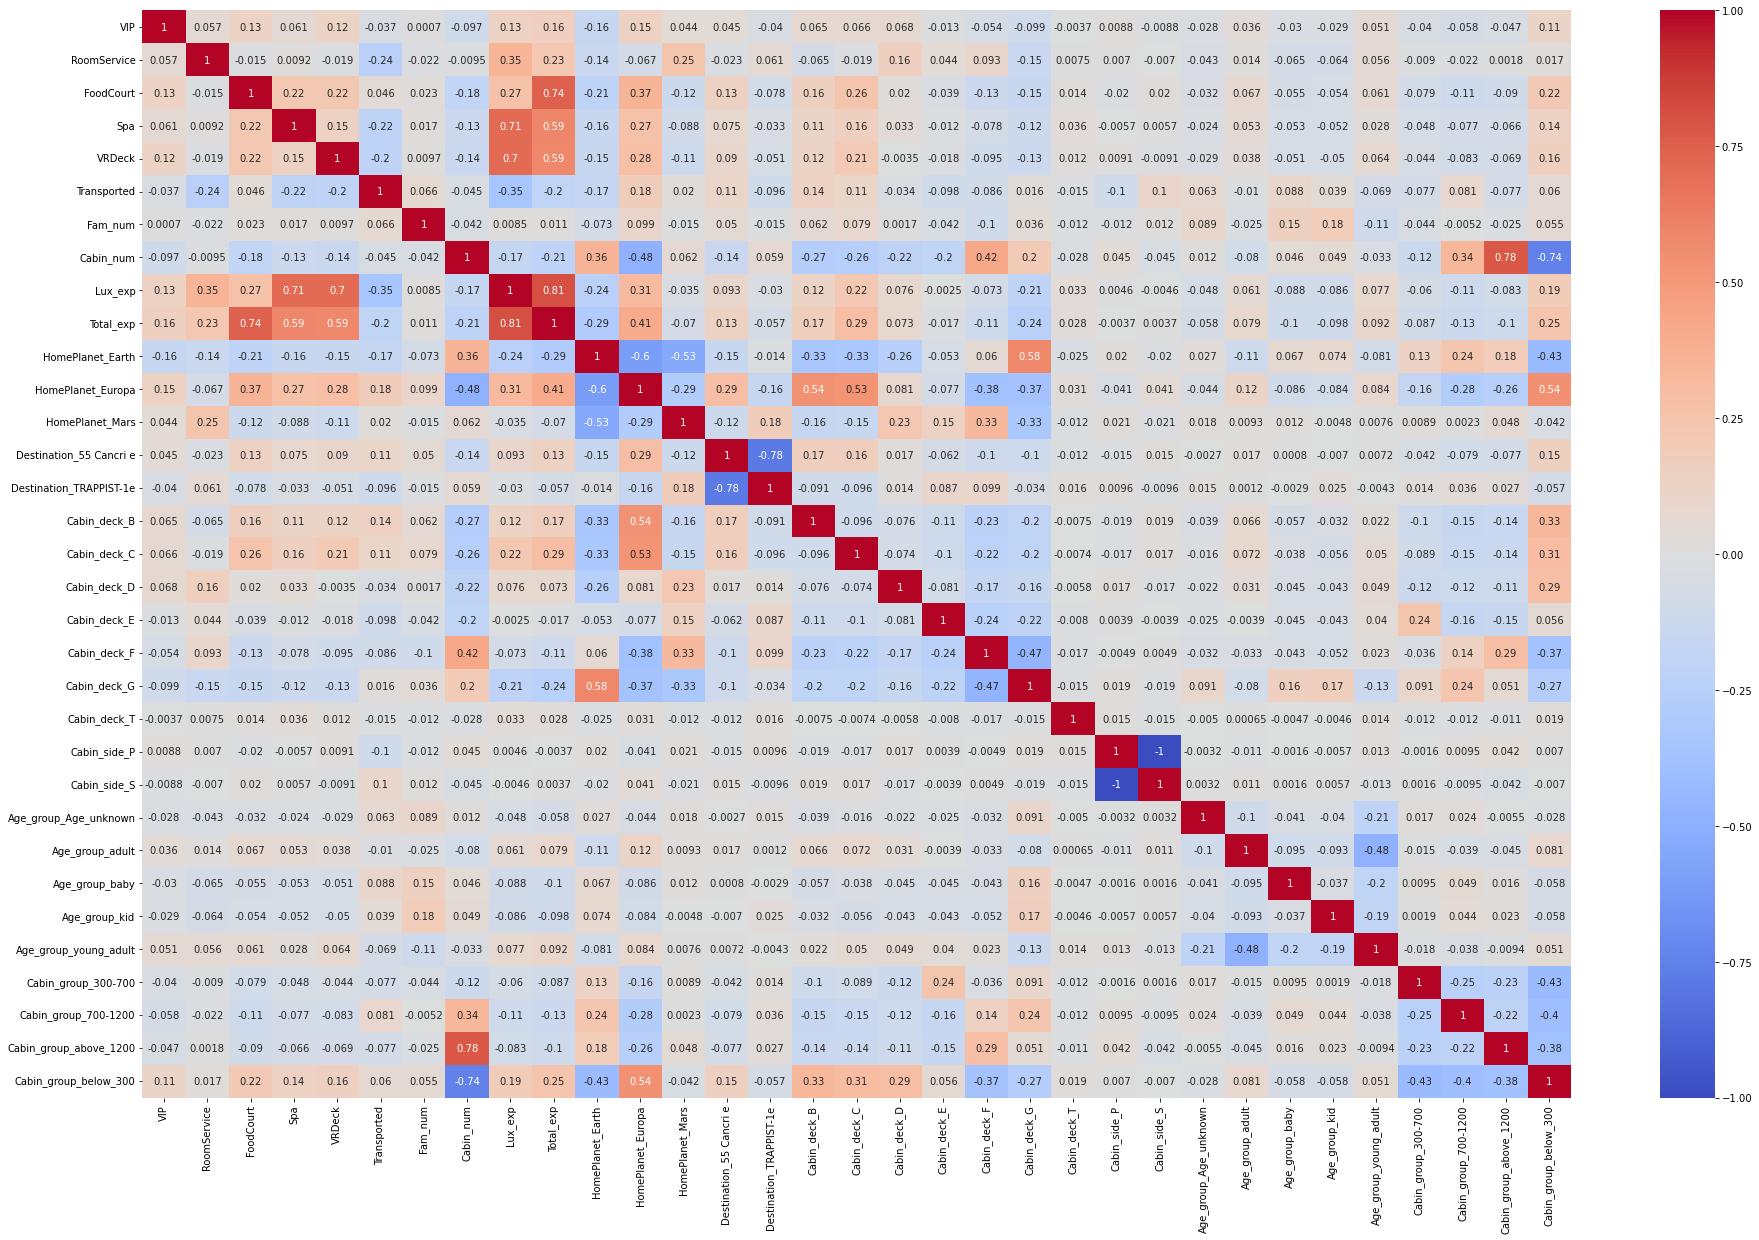

In [26]:
plt.figure(figsize = [32,20])
sns.heatmap(train_df.corr(), annot=True, cmap= 'coolwarm')
plt.show()

### Drop Target value

In [27]:
train_df= train_df.drop(columns=['Transported'], axis=1)
print(train_df.info())
print(test_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   VIP                      8693 non-null   float64
 1   RoomService              8693 non-null   float64
 2   FoodCourt                8693 non-null   float64
 3   Spa                      8693 non-null   float64
 4   VRDeck                   8693 non-null   float64
 5   Fam_num                  8693 non-null   int64  
 6   Cabin_num                8693 non-null   float64
 7   Lux_exp                  8693 non-null   float64
 8   Total_exp                8693 non-null   float64
 9   HomePlanet_Earth         8693 non-null   uint8  
 10  HomePlanet_Europa        8693 non-null   uint8  
 11  HomePlanet_Mars          8693 non-null   uint8  
 12  Destination_55 Cancri e  8693 non-null   uint8  
 13  Destination_TRAPPIST-1e  8693 non-null   uint8  
 14  Cabin_deck_B            

### Scaling

In [28]:
print(train_df.shape)
print(test_df.shape)

scaler = MinMaxScaler()
scaler.fit(train_df)
train_df_scaled=scaler.transform(train_df)

scaler.fit(test_df)
test_df_scaled=scaler.transform(test_df)

(8693, 32)
(4277, 32)


### Train Test Split

In [29]:
x_train, x_test, y_train, y_test= train_test_split(train_df_scaled, train_label, test_size=0.2, random_state=99)
# x_train, x_valid, y_train, y_valid= train_test_split(x_train, y_train,test_size= 0.2)


# ML

### KNN


In [32]:
KNN= KNeighborsClassifier()
KNN.fit(x_train, y_train)
y_pred= KNN.predict(x_test)
print('Accuracy:',accuracy_score(y_test, y_pred))
print('F-1 Score:',f1_score(y_test, y_pred))
# print('AUC:',roc_auc_score(y_test, KNN_pred_proba))


Accuracy: 0.7314548591144335
F-1 Score: 0.7415605976757057


In [33]:
%%time


KNN_param_grid={
    'n_neighbors': [3,5,7,9],
    'leaf_size': [15,20,25],
    'p': [1,2],
    'weights':['uniform', 'distance']
    }

KNN_cv= GridSearchCV(KNN, param_grid=KNN_param_grid , cv=5, scoring='accuracy' , n_jobs=-1)

KNN_cv.fit(x_train, y_train)


print(KNN_cv.best_params_, KNN_cv.best_score_)


# Compute Internal Metric Score

# print('classification report:\n',classification_report(y_test, y_pred))
# print('Accuracy:\n',accuracy_score(y_test, y_pred))
# print('F-1 Score:\n',f1_score(y_test, y_pred))
# KNN_pred_proba=KNN_cv.predict_proba(x_test)[:, 1]
# print('AUC:\n',roc_auc_score(y_test, KNN_pred_proba))

{'leaf_size': 15, 'n_neighbors': 5, 'p': 1, 'weights': 'distance'} 0.71599232475989
CPU times: user 471 ms, sys: 200 ms, total: 671 ms
Wall time: 7.52 s


In [34]:
# Compute Internal Metric Score
KNN= KNeighborsClassifier(leaf_size= 15,n_neighbors=5, p=1, weights= 'distance' )
KNN.fit(x_train, y_train)
y_pred= KNN.predict(x_test)

print('classification report:\n',classification_report(y_test, y_pred))
print('Accuracy:\n',accuracy_score(y_test, y_pred))
print('F-1 Score:\n',f1_score(y_test, y_pred))
KNN_pred_proba=KNN_cv.predict_proba(x_test)[:, 1]
print('AUC:\n',roc_auc_score(y_test, KNN_pred_proba))

classification report:
               precision    recall  f1-score   support

         0.0       0.75      0.70      0.72       854
         1.0       0.73      0.78      0.75       885

    accuracy                           0.74      1739
   macro avg       0.74      0.74      0.74      1739
weighted avg       0.74      0.74      0.74      1739

Accuracy:
 0.7366302472685451
F-1 Score:
 0.7497267759562842
AUC:
 0.8196152370367431


Avg KNN (20 times) : 0.7192934512570804


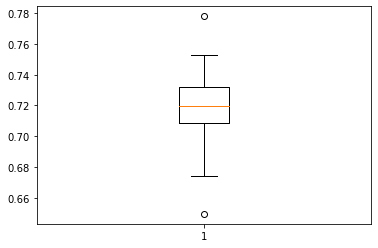

CPU times: user 979 ms, sys: 8.05 ms, total: 987 ms
Wall time: 987 ms


In [38]:
%%time

# run KNN for 20 time to evaluate model performance
KNN_cv_score=cross_val_score(KNN,x_train, y_train,cv=20, scoring= 'accuracy')

print('Avg KNN (20 times) :',KNN_cv_score.mean() )
plt.boxplot(KNN_cv_score)
plt.show()

### XGBoost

In [39]:
# baseline
XGB_cf= xgb.XGBClassifier()
XGB_cf.fit(x_train, y_train)
y_pred= XGB_cf.predict(x_test)
print('Accuracy:',accuracy_score(y_test, y_pred))
print('F-1 Score:',f1_score(y_test, y_pred))
# print('AUC:',roc_auc_score(y_test, KNN_pred_proba))



Accuracy: 0.8102357676825762
F-1 Score: 0.8129251700680272


## Find the best perameters

In [43]:
%%time
xgb_param_grid={
    'learning_rate':[ 0.1, 0.15, 0.2],
    'max_depth':[ 4, 5, 6],
    'gamma':[ 0.1, 0.15, 0.2],
    'colsample_bytree':[ 0.3, 0.5, 0.7],
    'min_child_weight':[2, 3, 4]
}


xgb_cv= GridSearchCV(XGB_cf, param_grid=xgb_param_grid , cv=5, scoring='accuracy' , n_jobs=-1)
xgb_cv.fit(x_train, y_train)
y_pred= xgb_cv.predict(x_test)
print(xgb_cv.best_params_, xgb_cv.best_score_)

print('Accuracy:\n :',accuracy_score(y_test, y_pred))
print('F-1 Score:\n',f1_score(y_test, y_pred))
XGB_pred_proba=xgb_cv.predict_proba(x_test)[:, 1]
print('AUC:\n',roc_auc_score(y_test, XGB_pred_proba))
      

#'colsample_bytree': 0.1, 'gamma': 0.1, 'learning_rate': 0.15, 'max_depth': 2, 'min_child_weight': 3

{'colsample_bytree': 0.5, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 2} 0.8064425468970619
Accuracy:
 : 0.8171362852213916
F-1 Score:
 0.8223463687150837
AUC:
 0.907171965757684
CPU times: user 5.86 s, sys: 909 ms, total: 6.77 s
Wall time: 1min 25s


## Apply the best perameters

In [44]:
%%time
# apply best parameters into the model
XGB_cf= xgb.XGBClassifier(colsample_bytree=0.5, gamma= 0.1, learning_rate=0.15, max_depth=6, min_child_weight=2)

XGB_cf.fit(x_train, y_train)
y_pred= XGB_cf.predict(x_test)

print('accuracy score:',accuracy_score(y_test, y_pred))

# print('XGB Validation Score:',xgb_cv.score(x_valid, y_valid))

print('confusion_matrix:\n',confusion_matrix(y_test, y_pred))
print('classification_report:\n',classification_report(y_test, y_pred))

accuracy score: 0.8205865439907993
confusion_matrix:
 [[692 162]
 [150 735]]
classification_report:
               precision    recall  f1-score   support

         0.0       0.82      0.81      0.82       854
         1.0       0.82      0.83      0.82       885

    accuracy                           0.82      1739
   macro avg       0.82      0.82      0.82      1739
weighted avg       0.82      0.82      0.82      1739

CPU times: user 2.77 s, sys: 562 ms, total: 3.33 s
Wall time: 619 ms


## Run Cross Validation

Avg xgb (20 times) : 0.8032731292855013


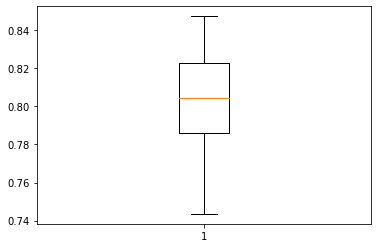

In [46]:
# run XGB for 20 time to evaluate model performance
XGB_cv_score=cross_val_score(XGB_cf,x_train, y_train,cv=20, scoring= 'accuracy')

print('Avg xgb (20 times) :',XGB_cv_score.mean() )
plt.boxplot(XGB_cv_score)
plt.show()

In [ ]:
XGB_df_predict= pd.DataFrame()
XGB_pred= xgb_cv.predict(test_df_scaled)
XGB_df_predict['Transported']= XGB_pred.astype(bool)
df_to_csv=pd.concat([test_label, XGB_df_predict['Transported']], axis=1)
df_to_csv.to_csv('XGB_prediction.csv', index=None)

## MLP


In [48]:
MLP= MLPClassifier(max_iter=2000)
MLP.fit(x_train, y_train)
y_pred= MLP.predict(x_test)
print('accuracy score:',accuracy_score(y_test, y_pred))
print('F-1 Score:\n',f1_score(y_test, y_pred))


accuracy score: 0.8073605520414031
F-1 Score:
 0.81663929939792


## Find the best perameters

In [54]:
%%time
MLP_param_grid={
'hidden_layer_sizes': [80, 100, 120],
    'learning_rate_init':[0.0001, 0.001, 0.005],
    'learning_rate':['constant', 'invscaling', 'adaptive'],
    'solver': ['sgd', 'adam']
}

MLP_cv= GridSearchCV(MLP, param_grid=MLP_param_grid , cv=5, scoring='accuracy' , n_jobs=-1)
MLP_cv.fit(x_train, y_train)
y_pred= MLP_cv.predict(x_test)

print(MLP_cv.best_params_, MLP_cv.best_score_)

{'hidden_layer_sizes': 80, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'solver': 'adam'} 0.8045735948983443
CPU times: user 46.2 s, sys: 12.6 s, total: 58.7 s
Wall time: 4min 2s


## Apply the best perameters

In [55]:
MLP= MLPClassifier(max_iter=2000, hidden_layer_sizes= 80 ,learning_rate_init= 0.001,learning_rate='adaptive' ,solver='adam' )
MLP.fit(x_train, y_train)
y_pred= MLP.predict(x_test)

print('accuracy score:',accuracy_score(y_test, y_pred))
print('F-1 Score:\n',f1_score(y_test, y_pred))
print('confusion_matrix:\n',confusion_matrix(y_test, y_pred))
print('classification_report:\n',classification_report(y_test, y_pred))
# MLP_pred_proba=MLP_cv.predict_proba(x_test)[:, 1]
# print('AUC:\n',roc_auc_score(y_test, MLP_pred_proba))

accuracy score: 0.8062104657849338
F-1 Score:
 0.8105677346824058
confusion_matrix:
 [[681 173]
 [164 721]]
classification_report:
               precision    recall  f1-score   support

         0.0       0.81      0.80      0.80       854
         1.0       0.81      0.81      0.81       885

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739



## Run Cross Validation

run MLP 20 times: 0.8028466494418497


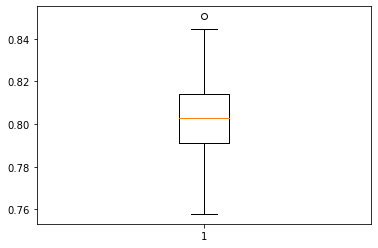

CPU times: user 10min 9s, sys: 2min 41s, total: 12min 50s
Wall time: 3min 30s


In [56]:
%%time
MLP_cv_score=cross_val_score(MLP,x_train, y_train,cv=20, scoring= 'accuracy')

print('run MLP 20 times:',MLP_cv_score.mean() )
plt.boxplot(MLP_cv_score)
plt.show()

In [57]:
MLP_df_predict= pd.DataFrame()
# MLP_new = MLPClassifier(max_iter=2000,learning_rate= 'adaptive', learning_rate_init=0.0001, solver= 'adam', hidden_layer_sizes= 100)
# MLP_new.fit(x_train, y_train)
# MLP_pred= MLP_new.predict(test_df_scaled)
MLP_df_predict['Transported']= y_pred.astype(bool)

# MLP_df_predict['Transported']= MLP_pred.astype(bool)
df_to_csv=pd.concat([test_label, MLP_df_predict['Transported']], axis=1)
df_to_csv.to_csv('MLP_prediction.csv', index=None)

### Model Performace Comparison

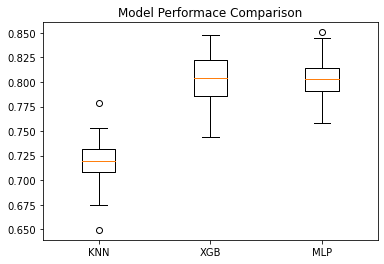

In [58]:
plt.boxplot([KNN_cv_score, XGB_cv_score, MLP_cv_score])
plt.title('Model Performace Comparison')
plt.xticks([1,2,3],['KNN', 'XGB', 'MLP'])
plt.show()